In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# # IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# # TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# # THEN FEEL FREE TO DELETE THIS CELL.
# # NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# # ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# # NOTEBOOK.

# import os
# import sys
# from tempfile import NamedTemporaryFile
# from urllib.request import urlopen
# from urllib.parse import unquote, urlparse
# from urllib.error import HTTPError
# from zipfile import ZipFile
# import tarfile
# import shutil

# CHUNK_SIZE = 40960
# DATA_SOURCE_MAPPING = 'it-service-ticket-classification-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4460055%2F7650678%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240730%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240730T134818Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5740a25a18cc0388490db8652ed92ae6bec92148892c35e56ebbbf05015424cf6817114897d6aa67016e987e98ff238221d6e2a4db46aaf2864ad568e859f9ceb232d0019decf9a497e26d146053b64af5ec8e5bd915b3f9e7c642b3088d45d05c13fb4baaae636ba94e37e4f798a97d1346a69d2eafbc313d4127e41a1607a242fc797e566bfa3ef3f56fc630a89eeb1174e13047b2e6d3b70df464dca745de8b5e47ae40d5277ccbf65c4287d2019098baf2519b8d349eda212b7ee4f05af463b4b95f0378936184f2ccff07653fe1e0751b0b97a7dced51982931b948225a261e2bd7bbed84d88611bf0539e12ebe1954b0cad8f04b06d37ad42c1016ff09'

# KAGGLE_INPUT_PATH='/kaggle/input'
# KAGGLE_WORKING_PATH='/kaggle/working'
# KAGGLE_SYMLINK='kaggle'

# !umount /kaggle/input/ 2> /dev/null
# shutil.rmtree('/kaggle/input', ignore_errors=True)
# os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
# os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

# try:
#   os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
# except FileExistsError:
#   pass
# try:
#   os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
# except FileExistsError:
#   pass

# for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
#     directory, download_url_encoded = data_source_mapping.split(':')
#     download_url = unquote(download_url_encoded)
#     filename = urlparse(download_url).path
#     destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
#     try:
#         with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
#             total_length = fileres.headers['content-length']
#             print(f'Downloading {directory}, {total_length} bytes compressed')
#             dl = 0
#             data = fileres.read(CHUNK_SIZE)
#             while len(data) > 0:
#                 dl += len(data)
#                 tfile.write(data)
#                 done = int(50 * dl / int(total_length))
#                 sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
#                 sys.stdout.flush()
#                 data = fileres.read(CHUNK_SIZE)
#             if filename.endswith('.zip'):
#               with ZipFile(tfile) as zfile:
#                 zfile.extractall(destination_path)
#             else:
#               with tarfile.open(tfile.name) as tarfile:
#                 tarfile.extractall(destination_path)
#             print(f'\nDownloaded and uncompressed: {directory}')
#     except HTTPError as e:
#         print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
#         continue
#     except OSError as e:
#         print(f'Failed to load {download_url} to path {destination_path}')
#         continue

# print('Data source import complete.')


# Service Ticket Classification with Recurrent Neural Networks

In the era of ongoing digital transformation, electronic service tickets have become indispensable tools for companies to manage requests efficiently. However, the sheer volume of tickets poses challenges in timely triaging and assignment to the right resolution teams, impacting service-level agreements and customer satisfaction.

Therefore, this project aims to address this challenge by automating the classification of e-service tickets into appropriate categories.

The notebook explores the implementation of various sequence-based deep learning models, including RNN, LSTM, GRU, Bidirectional LSTM & GRUs, as well as combination architectures involving CNNs.

While this notebook focuses on exploring traditional sequence-based deep learning models, it can serve as a baseline for comparison with more advanced NLP models, such as Transformer-based architectures like BERT, GPT, or RoBERTa.

Original Dataset Source: https://github.com/karolzak/support-tickets-classification#22-dataset

Contents:
1.   Data Pre-processing
2.   RNN
3.   LSTM
4.   Bidirectional LSTM
5.   Bidirectional GRU
6.   CNN + Bidirectional GRU
7.   Discussion & Future Work

# 1. Data Pre-Processing

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import random

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.models import Model

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # Copy the file path into "tickets_path" below

### i. Text Exploration

The dataset consists of 47837 rows and 2 columns.

The 'Document' column contains the full text of the e-service ticket that was  logged.

The 'Topic_group' columns contains the classification or topic of the ticket. <br>There are 8 possible topics - 'Hardware', 'Access', 'Storage', 'Internal Project', 'HR Support', 'Administrative rights', 'Purchase', 'Miscellaneous'.

In [ ]:
# Read the CSV into a pandas dataframe
tickets_path = "/content/drive/MyDrive/it/all_tickets_processed_improved_v3.csv"
tickets_df = pd.read_csv(tickets_path)

print(tickets_df.shape)
tickets_df.head()

(47837, 2)


,Document,Topic_group
0,connection with icon icon dear please setup ic...,Hardware
1,work experience user work experience user hi w...,Access
2,requesting for meeting requesting meeting hi p...,Hardware
3,reset passwords for external accounts re expir...,Access
4,mail verification warning hi has got attached ...,Miscellaneous


In [ ]:
# shuffle the DataFrame rows
tickets_df = tickets_df.sample(frac=1, random_state=28)

tickets_df.head()

,Document,Topic_group
40715,federation service seems to have changed sent ...,Hardware
2292,mail dear please create possibility mails whic...,Miscellaneous
22204,creation of a mail called am team wednesday pm...,Miscellaneous
43308,password reset for tine hello there let ask me...,Access
10378,access to confluence wednesday pm confluence d...,Access


Unique categories: ['Hardware' 'Miscellaneous' 'Access' 'Storage' 'Internal Project'
 'HR Support' 'Administrative rights' 'Purchase'] 

Topic_group
Hardware                 13617
HR Support               10915
Access                    7125
Miscellaneous             7060
Storage                   2777
Purchase                  2464
Internal Project          2119
Administrative rights     1760
Name: count, dtype: int64 



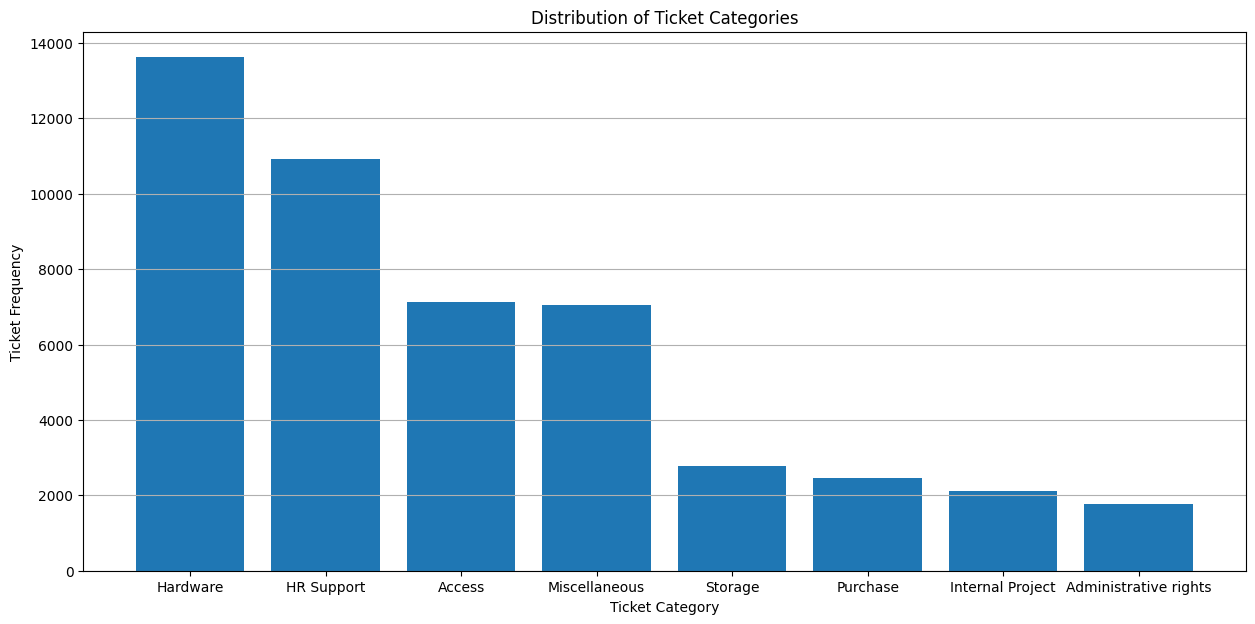

In [ ]:
# Find the unique values in the "Topic_group" column
unique_categories = tickets_df['Topic_group'].unique()
print("Unique categories:", unique_categories, "\n")

# Plot a bar plot showing the distribution of categories
category_counts = tickets_df['Topic_group'].value_counts()
print(category_counts, "\n")

fig, ax = plt.subplots(figsize=(15,7))
ax.bar(category_counts.index, category_counts.values)
ax.set_xlabel("Ticket Category")
ax.set_ylabel("Ticket Frequency")
ax.set_title("Distribution of Ticket Categories")
ax.grid(visible=True, axis = 'y')
plt.show()

To balance out the dataset, downsample the majority classes (Hardware, HR Support, Access, Miscellaneous) such that there are only 5000 rows each.

In [ ]:
# Get the indices for each category
hardware_indices = tickets_df[tickets_df['Topic_group'] == 'Hardware'].index
hr_support_indices = tickets_df[tickets_df['Topic_group'] == 'HR Support'].index
access_indices = tickets_df[tickets_df['Topic_group'] == 'Access'].index
miscellaneous_indices = tickets_df[tickets_df['Topic_group'] == 'Miscellaneous'].index

# Create a list of indices to drop
indices_to_drop = random.sample(list(hardware_indices), len(hardware_indices) - 5000) + \
                  random.sample(list(hr_support_indices), len(hr_support_indices) - 5000) + \
                  random.sample(list(access_indices), len(access_indices) - 5000) + \
                  random.sample(list(miscellaneous_indices), len(miscellaneous_indices) - 5000)

# Drop the rows
tickets_df_downsample = tickets_df.drop(indices_to_drop)

# Check the number of rows for each category
print(tickets_df_downsample.shape)
print("Hardware count:", tickets_df_downsample[tickets_df_downsample['Topic_group'] == 'Hardware'].shape[0])
print("HR Support count:", tickets_df_downsample[tickets_df_downsample['Topic_group'] == 'HR Support'].shape[0])
print("Access count:", tickets_df_downsample[tickets_df_downsample['Topic_group'] == 'Access'].shape[0])
print("Miscellaneous count:", tickets_df_downsample[tickets_df_downsample['Topic_group'] == 'Miscellaneous'].shape[0])

tickets_df_downsample.head()

(29120, 2)
Hardware count: 5000
HR Support count: 5000
Access count: 5000
Miscellaneous count: 5000


,Document,Topic_group
2292,mail dear please create possibility mails whic...,Miscellaneous
22204,creation of a mail called am team wednesday pm...,Miscellaneous
43308,password reset for tine hello there let ask me...,Access
37222,not working properly working properly hello we...,Hardware
12436,change july pm change hello please update than...,Miscellaneous


Unique categories: ['Miscellaneous' 'Access' 'Hardware' 'Storage' 'Internal Project'
 'HR Support' 'Administrative rights' 'Purchase'] 

Topic_group
Miscellaneous            5000
Access                   5000
Hardware                 5000
HR Support               5000
Storage                  2777
Purchase                 2464
Internal Project         2119
Administrative rights    1760
Name: count, dtype: int64 



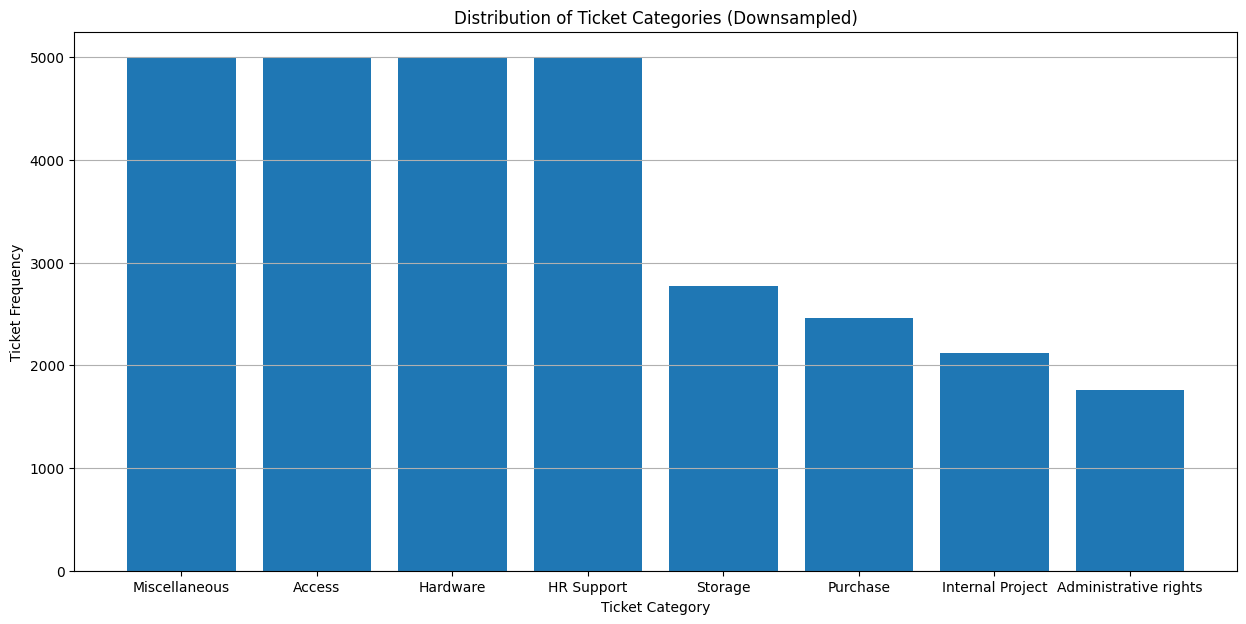

In [ ]:
# Find the unique values in the "Topic_group" column
unique_categories = tickets_df_downsample['Topic_group'].unique()
print("Unique categories:", unique_categories, "\n")

# Plot a bar plot showing the distribution of categories
category_counts = tickets_df_downsample['Topic_group'].value_counts()
print(category_counts, "\n")

fig, ax = plt.subplots(figsize=(15,7))
ax.bar(category_counts.index, category_counts.values)
ax.set_xlabel("Ticket Category")
ax.set_ylabel("Ticket Frequency")
ax.set_title("Distribution of Ticket Categories (Downsampled)")
ax.grid(visible=True, axis = 'y')
plt.show()

### ii. Text Vectorisation & Splitting to Train-Validation-Test Data

In [ ]:
# Split the data into training/validation (95%) and testing (5%) sets
testing_samples = int(len(tickets_df_downsample) * 0.05)
tickets_df_test = tickets_df_downsample[:testing_samples]
tickets_df_train_val = tickets_df_downsample[testing_samples:]

# Split the rest of the data into training (80%) & validation (20%) sets
training_samples = int(len(tickets_df_train_val) * 0.8)
tickets_df_train = tickets_df_train_val[:training_samples]
tickets_df_val = tickets_df_train_val[training_samples:]

print("Training: ", tickets_df_train.shape)
print("Validation: ", tickets_df_val.shape)
print("Testing: ", tickets_df_test.shape)

Training:  (22131, 2)
Validation:  (5533, 2)
Testing:  (1456, 2)


In [ ]:
# Vocabulary size and number of words in a sequence.
VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 200
# Max length: if < 200, pad with zeros. if longer, truncate

# Use the text vectorization layer to normalize, split, and map strings to integers.
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = keras.layers.TextVectorization(
    max_tokens=10000,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    output_mode='int',
    output_sequence_length=200
)

In [ ]:
# Call adapt on the Training dataset to build the vocabulary.
vectorize_layer.adapt(tickets_df_train['Document'].values)

In [ ]:
VOCAB_SIZE = len(vectorize_layer.get_vocabulary())
print(VOCAB_SIZE)

9576


In [ ]:
# Vectorize the ticket text ('Document') in the training, validation & testing dataset
train_text = vectorize_layer(tickets_df_train['Document'].values)
val_text = vectorize_layer(tickets_df_val['Document'].values)
test_text = vectorize_layer(tickets_df_test['Document'].values)

print("Training: ", train_text.shape)
print("Validation: ", val_text.shape)
print("Testing: ", test_text.shape)

train_text

Training:  (22131, 200)
Validation:  (5533, 200)
Testing:  (1456, 200)


<tf.Tensor: shape=(22131, 200), dtype=int64, numpy=
array([[ 40,  75,   7, ...,   0,   0,   0],
       [ 87,  14,   7, ...,   0,   0,   0],
       [137,  24,  14, ...,   0,   0,   0],
       ...,
       [228,   4, 310, ...,   0,   0,   0],
       [  2,  17,  14, ...,   0,   0,   0],
       [205, 735,  65, ...,   0,   0,   0]])>

In [ ]:
# One-hot encode the labels ('Topic_group')
train_labels = pd.get_dummies(tickets_df_train['Topic_group']).to_numpy()
val_labels = pd.get_dummies(tickets_df_val['Topic_group']).to_numpy()
test_labels = pd.get_dummies(tickets_df_test['Topic_group']).to_numpy()

print("Training: ", train_labels.shape)
print("Validation: ", val_labels.shape)
print("Testing: ", test_labels.shape)

train_labels

Training:  (22131, 8)
Validation:  (5533, 8)
Testing:  (1456, 8)


array([[False, False, False, ..., False,  True, False],
       [False,  True, False, ..., False, False, False],
       [False, False, False, ..., False, False,  True],
       ...,
       [ True, False, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

### iii. Helper Functions

In [ ]:
# Use the model_checkpoint_callback to save our best checkpoint in terms of validation accuracy.

def save_best_model(checkpoint_path):

    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    return model_checkpoint_callback


# This function is used to display the history the train/test accuracy/loss of the Keras training.

def display_training_loss_and_accuracy(history):

    plt.figure(figsize=(20,4))

    # summarize history for accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')

    # summarize history for loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()


# Define function to display confusion matrix & classification report

def display_classification_confusion_matrix(keras_model, x_train, y_train, x_test, y_test, labels):

    x_train = np.array(x_train)
    y_train = np.array(y_train)

    actual_y_train = keras_model.predict(x_train)
    actual_y_test = keras_model.predict(x_test)

    plt.figure(figsize=(20,6))

    labels = np.array(labels)

    # Convert the target labels into the categorical index
    #
    y_train_index = y_train.argmax(axis=1)
    actual_y_train_index = actual_y_train.argmax(axis=1)
    y_test_index = y_test.argmax(axis=1)
    actual_y_test_index = actual_y_test.argmax(axis=1)


    # Print the first Confusion Matrix for the training data
    #
    cm = confusion_matrix(y_train_index, actual_y_train_index)

    cm_df = pd.DataFrame(cm, labels, labels)
    plt.subplot(1, 2, 1)
    plt.title('Confusion Matrix (Train Data)')
    sns.heatmap(cm_df, annot=True)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    # Print the second Confusion Matrix for the test data
    #
    cm = confusion_matrix(y_test_index, actual_y_test_index)


    cm_df = pd.DataFrame(cm, labels, labels)
    plt.subplot(1, 2, 2)
    plt.title('Confusion Matrix (Test Data)')
    sns.heatmap(cm_df, annot=True)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    plt.show()

    # Finally display the classification reports
    #
    print ("Train Data:")
    print ("--------------------------------------------------------")
    print(classification_report(actual_y_train_index, y_train_index, target_names=labels))
    print ("")
    print ("Test Data:")
    print ("--------------------------------------------------------")
    print(classification_report(actual_y_test_index, y_test_index, target_names=labels))

# 6. CNN + Bidirectional GRU


### Build Convolutional + Bidirectional GRU model with Dense & Dropout layers

- SpatialDropout1D (0.2)
- Bidirectional GRU (128, tanh)
- Conv1D (64)
- concatenate: GlobalAveragePooling1D + GlobalMaxPooling1D
- Dense (**32**, relu)
- Dropout (0.5)



Combining Convolutional and Gated Recurrent Unit (GRU) layers in a neural network architecture offers complementary benefits for sequential data processing. Convolutional layers excel at extracting spatial features, capturing local patterns in the input sequence. Meanwhile, GRU layers are proficient in modeling temporal dependencies, capturing long-range sequential patterns. By leveraging both architectures, the model can learn hierarchical representations, effectively capturing both local and global patterns within the data. This combination optimizes computation, as Conv layers efficiently process spatial features in parallel while GRU layers sequentially capture temporal dependencies, resulting in improved performance and generalization.

The model begins with a SpatialDropout1D layer to regularize the input data, followed by a Bidirectional GRU layer with 128 units and a hyperbolic tangent activation function. A Conv1D layer with 64 filters is then applied to extract higher-level features. The output from these layers is concatenated with both GlobalAveragePooling1D and GlobalMaxPooling1D layers to capture different aspects of the sequence information. Finally, a Dense layer with 32 units and a rectified linear unit (ReLU) activation function is applied, followed by a Dropout layer with a dropout rate of 0.5 to prevent overfitting.






In [ ]:
EMBEDDING_DIM=128

inputs = keras.Input(shape=(MAX_SEQUENCE_LENGTH,))

embedded = keras.layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBEDDING_DIM,
                                  mask_zero=True)(inputs)

# GRU Example:
x = keras.layers.SpatialDropout1D(0.2)(embedded)
x = keras.layers.Bidirectional(keras.layers.GRU(128, return_sequences=True))(x)
x = keras.layers.Conv1D(64, kernel_size=3, padding = "valid", kernel_initializer = "glorot_uniform")(x)
avg_pool = keras.layers.GlobalAveragePooling1D()(x)
max_pool = keras.layers.GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool])
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = keras.layers.Dense(8, activation='softmax')(x)   # 8 categories

model_CNN_GRU = keras.Model(inputs, outputs)

model_CNN_GRU.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model_CNN_GRU.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 200, 128)             1225728   ['input_1[0][0]']             
                                                                                                  
 spatial_dropout1d (Spatial  (None, 200, 128)             0         ['embedding[0][0]']           
 Dropout1D)                                                                                       
                                                                                                  
 bidirectional (Bidirection  (None, 200, 256)             198144    ['spatial_dropout1d[0][0]'

In [ ]:
history_spec_model_CNN_GRU = model_CNN_GRU.fit(
    train_text,
    train_labels,
    validation_data=(val_text, val_labels),
    epochs=7,
    batch_size=32,
    callbacks=[save_best_model('best_checkpoint_7E_bilstm')])

Epoch 1/7
692/692 [==============================] - 449s 633ms/step - loss: 1.7876 - accuracy: 0.3048 - val_loss: 1.1530 - val_accuracy: 0.6485
Epoch 2/7
692/692 [==============================] - 431s 622ms/step - loss: 1.0864 - accuracy: 0.6134 - val_loss: 0.7880 - val_accuracy: 0.7576
Epoch 3/7
692/692 [==============================] - 454s 657ms/step - loss: 0.8254 - accuracy: 0.7298 - val_loss: 0.6572 - val_accuracy: 0.8032
Epoch 4/7
692/692 [==============================] - 452s 654ms/step - loss: 0.6845 - accuracy: 0.7794 - val_loss: 0.6153 - val_accuracy: 0.8171
Epoch 5/7
692/692 [==============================] - 430s 622ms/step - loss: 0.6133 - accuracy: 0.8094 - val_loss: 0.5979 - val_accuracy: 0.8205
Epoch 6/7
692/692 [==============================] - 433s 625ms/step - loss: 0.5555 - accuracy: 0.8271 - val_loss: 0.5681 - val_accuracy: 0.8312
Epoch 7/7
692/692 [==============================] - 470s 679ms/step - loss: 0.5032 - accuracy: 0.8447 - val_loss: 0.5471 - val_ac

46/46 [==============================] - 19s 398ms/step - loss: 0.4813 - accuracy: 0.8468


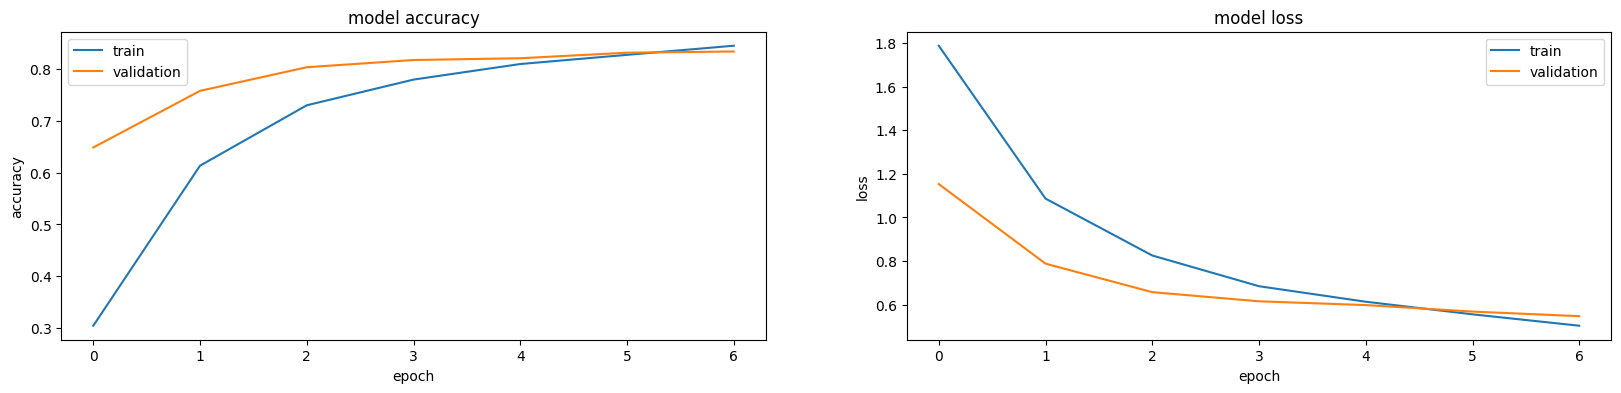

46/46 [==============================] - 5s 106ms/step


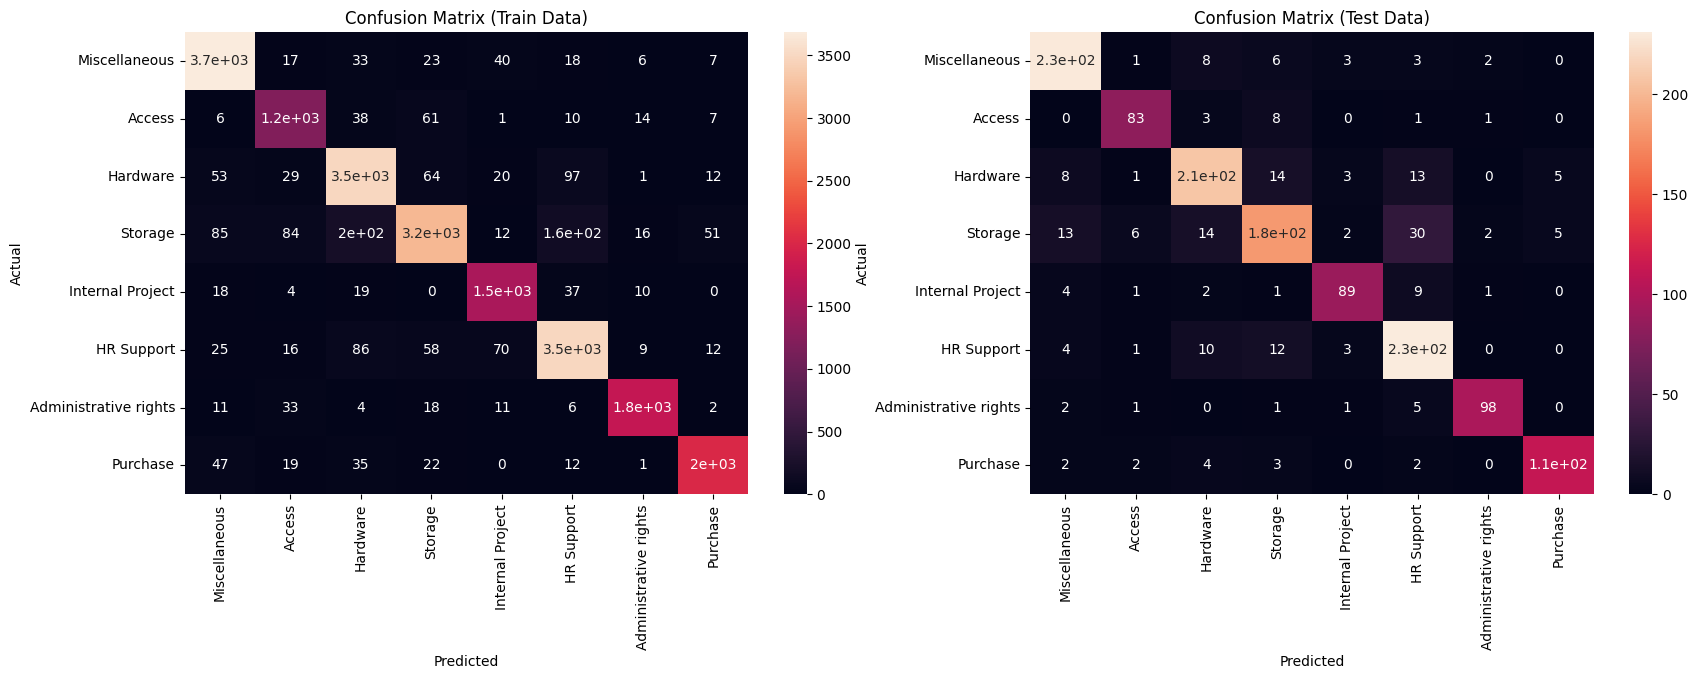

Train Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.96      0.94      0.95      3929
               Access       0.90      0.86      0.88      1405
             Hardware       0.93      0.89      0.91      3903
              Storage       0.84      0.93      0.88      3432
     Internal Project       0.95      0.91      0.93      1703
           HR Support       0.93      0.91      0.92      3835
Administrative rights       0.95      0.97      0.96      1828
             Purchase       0.94      0.96      0.95      2096

             accuracy                           0.92     22131
            macro avg       0.92      0.92      0.92     22131
         weighted avg       0.92      0.92      0.92     22131


Test Data:
--------------------------------------------------------
                       precision    recall  f1-score   support

        Miscellaneous       0.91      0

In [ ]:
model_CNN_GRU.load_weights("best_checkpoint_7E_bilstm")

# Evaluate on test data
model_CNN_GRU.evaluate(x=test_text, y=test_labels)

# Display Training History
display_training_loss_and_accuracy(history_spec_model_CNN_GRU)

# Display confusion matrix & classification report
display_classification_confusion_matrix(model_CNN_GRU, train_text, train_labels, test_text, test_labels, unique_categories)

In [ ]:
model_CNN_GRU.save('/content/drive/MyDrive/it/model_CNN_GRU_final.keras')
# model_CNN_GRU.save('model_CNN_GRU_final.keras')


# 7. Discussion & Future Work



The best model with a good testing accuracy as well as a fairly low varience is the CNN + Bidirectional GRU model, with the architecture outlined below.

- SpatialDropout1D(0.2)
- Bidirectional GRU(128, tanh)
- Conv1D(64, kernel_size=3)
- GlobalAveragePooling1D + GlobalMaxPooling1D
- Dense(32, ReLU)
- Dropout (0.5)
- Dense (8, softmax)

Hyperparameters:
- Optimizer: Adam, learning rate = 0.0001
- Batch size: 32
- Epochs: 7

Results:
- Training accuracy: 0.8501
- Validation accuracy: 0.8366
- Testing accuracy: 0.8462


Training curve:

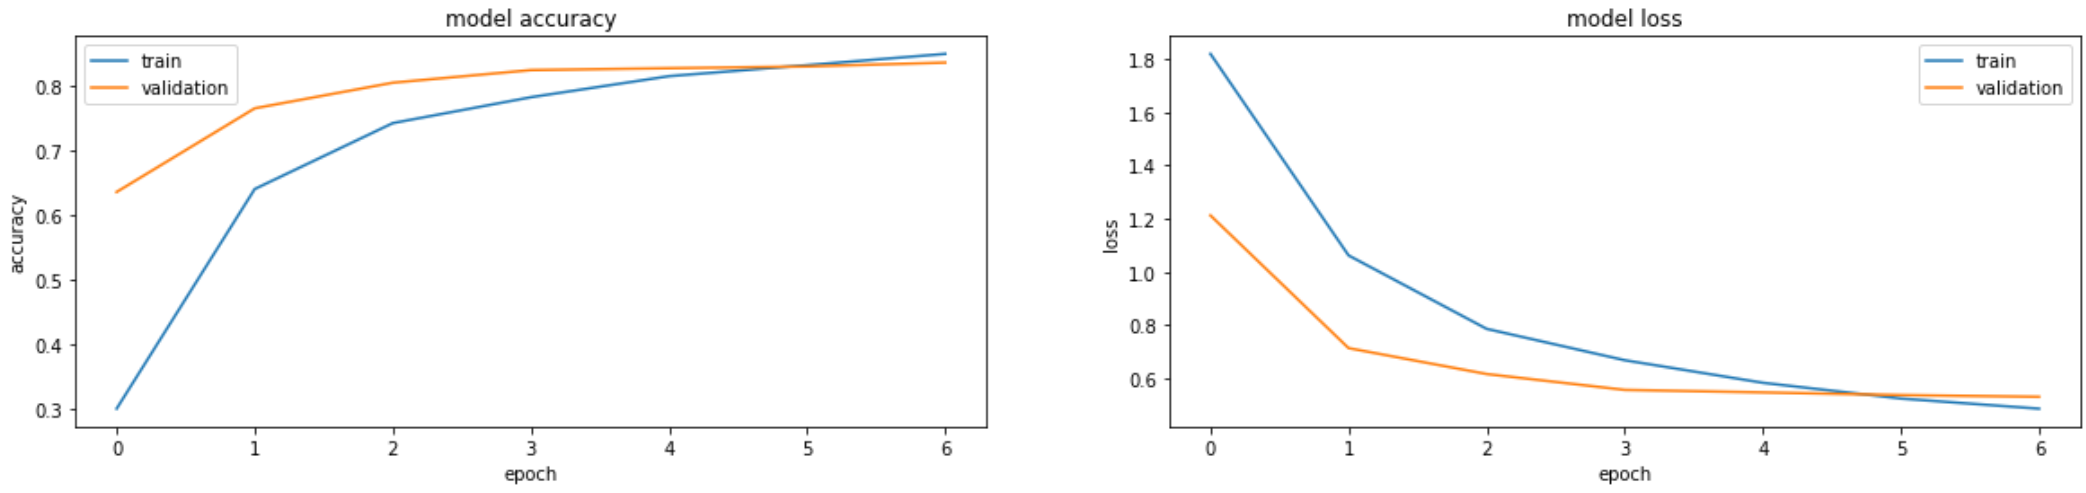

Classification report & Confusion matrix:

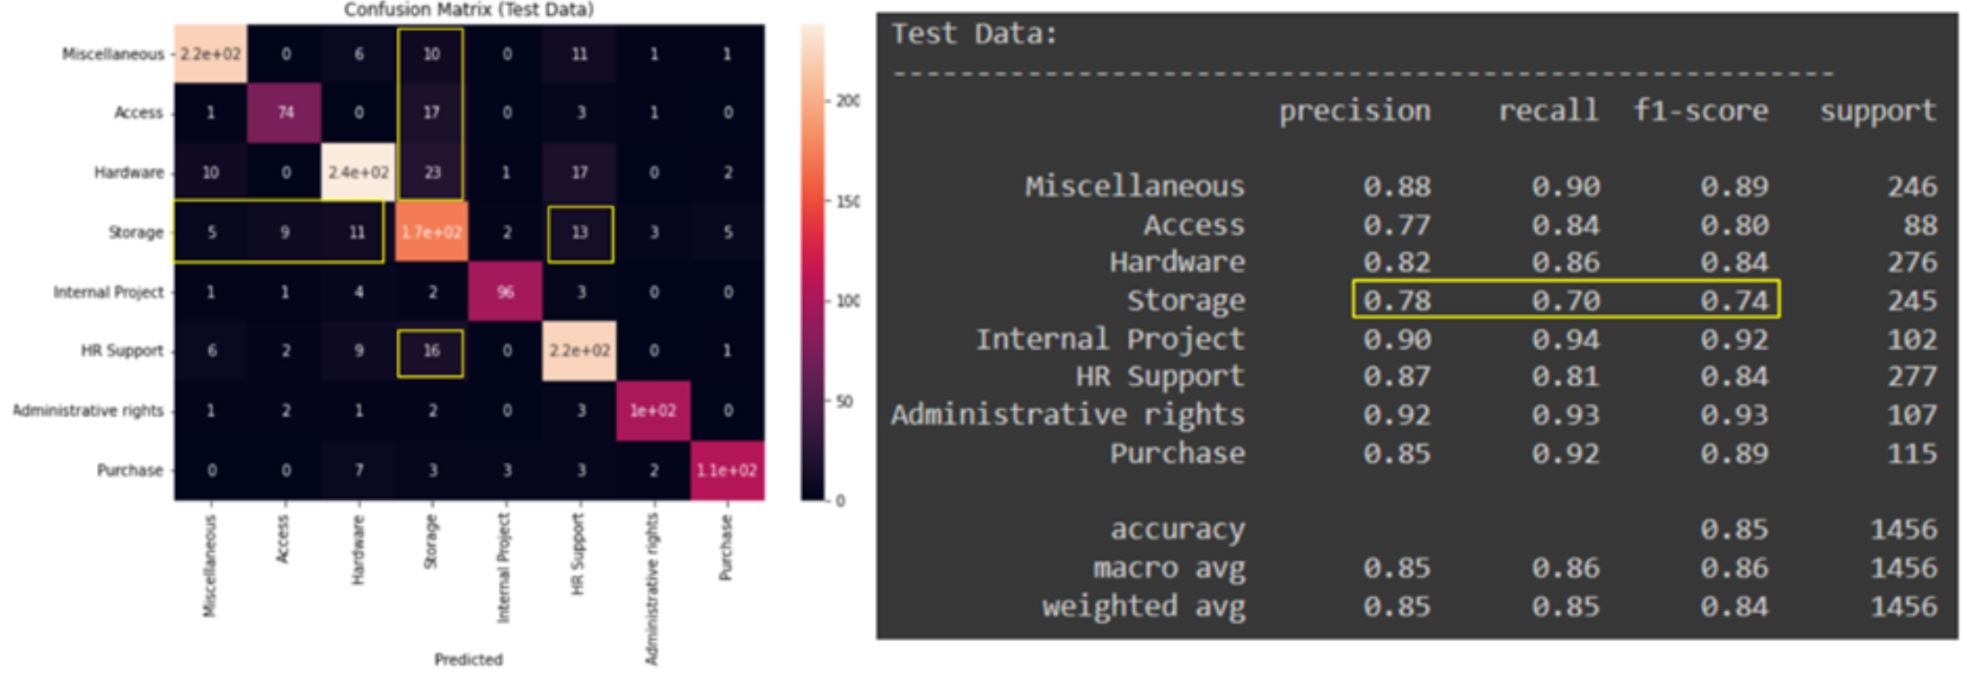

The CNN + Bidir GRU model achieved promising results in the ticket classification task.

In the training data, the model displayed high precision, recall, and F1-score across various ticket categories, with an overall accuracy of 92%. Notably, categories like Miscellaneous, Administrative rights, and Purchase exhibited particularly strong performance, with F1-scores exceeding 0.95.

However, when evaluated on the test data, the model's performance slightly declined, achieving an accuracy of 85%. While precision, recall, and F1-scores remained relatively high across most categories, there was a noticeable decrease in performance for categories like Storage and HR Support. This suggests that the model may be overfitting to the training data to some extent, as it did not generalize as well to unseen examples. Further optimization or regularization techniques might be necessary to enhance the model's performance on the test data.

Additionally, a detailed analysis of the misclassified examples can help identify common patterns or words that are causing the confusion. Based on this information, more sample data may be introduced to training the model to better distinguish between the classes. Apart from that, while the Adam optimizer with learning rate of 0.0001 generally worked well and is useful for text classification, other optimizers such as RMSprop or Adagrad, or varying of hyperparameters such as the learning rate or batch size may also be trialed to find the best combination for this project.

Overall, while this notebook focuses on exploring traditional sequence-based deep learning models, it can serve as a baseline for comparison with more advanced NLP models, such as Transformer-based architectures like BERT, GPT, or RoBERTa.
